In [6]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

test_flattend_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_flattened_sorted = np.sort(torch.load("samples.pt", map_location=torch.device('cpu')).numpy().flatten())

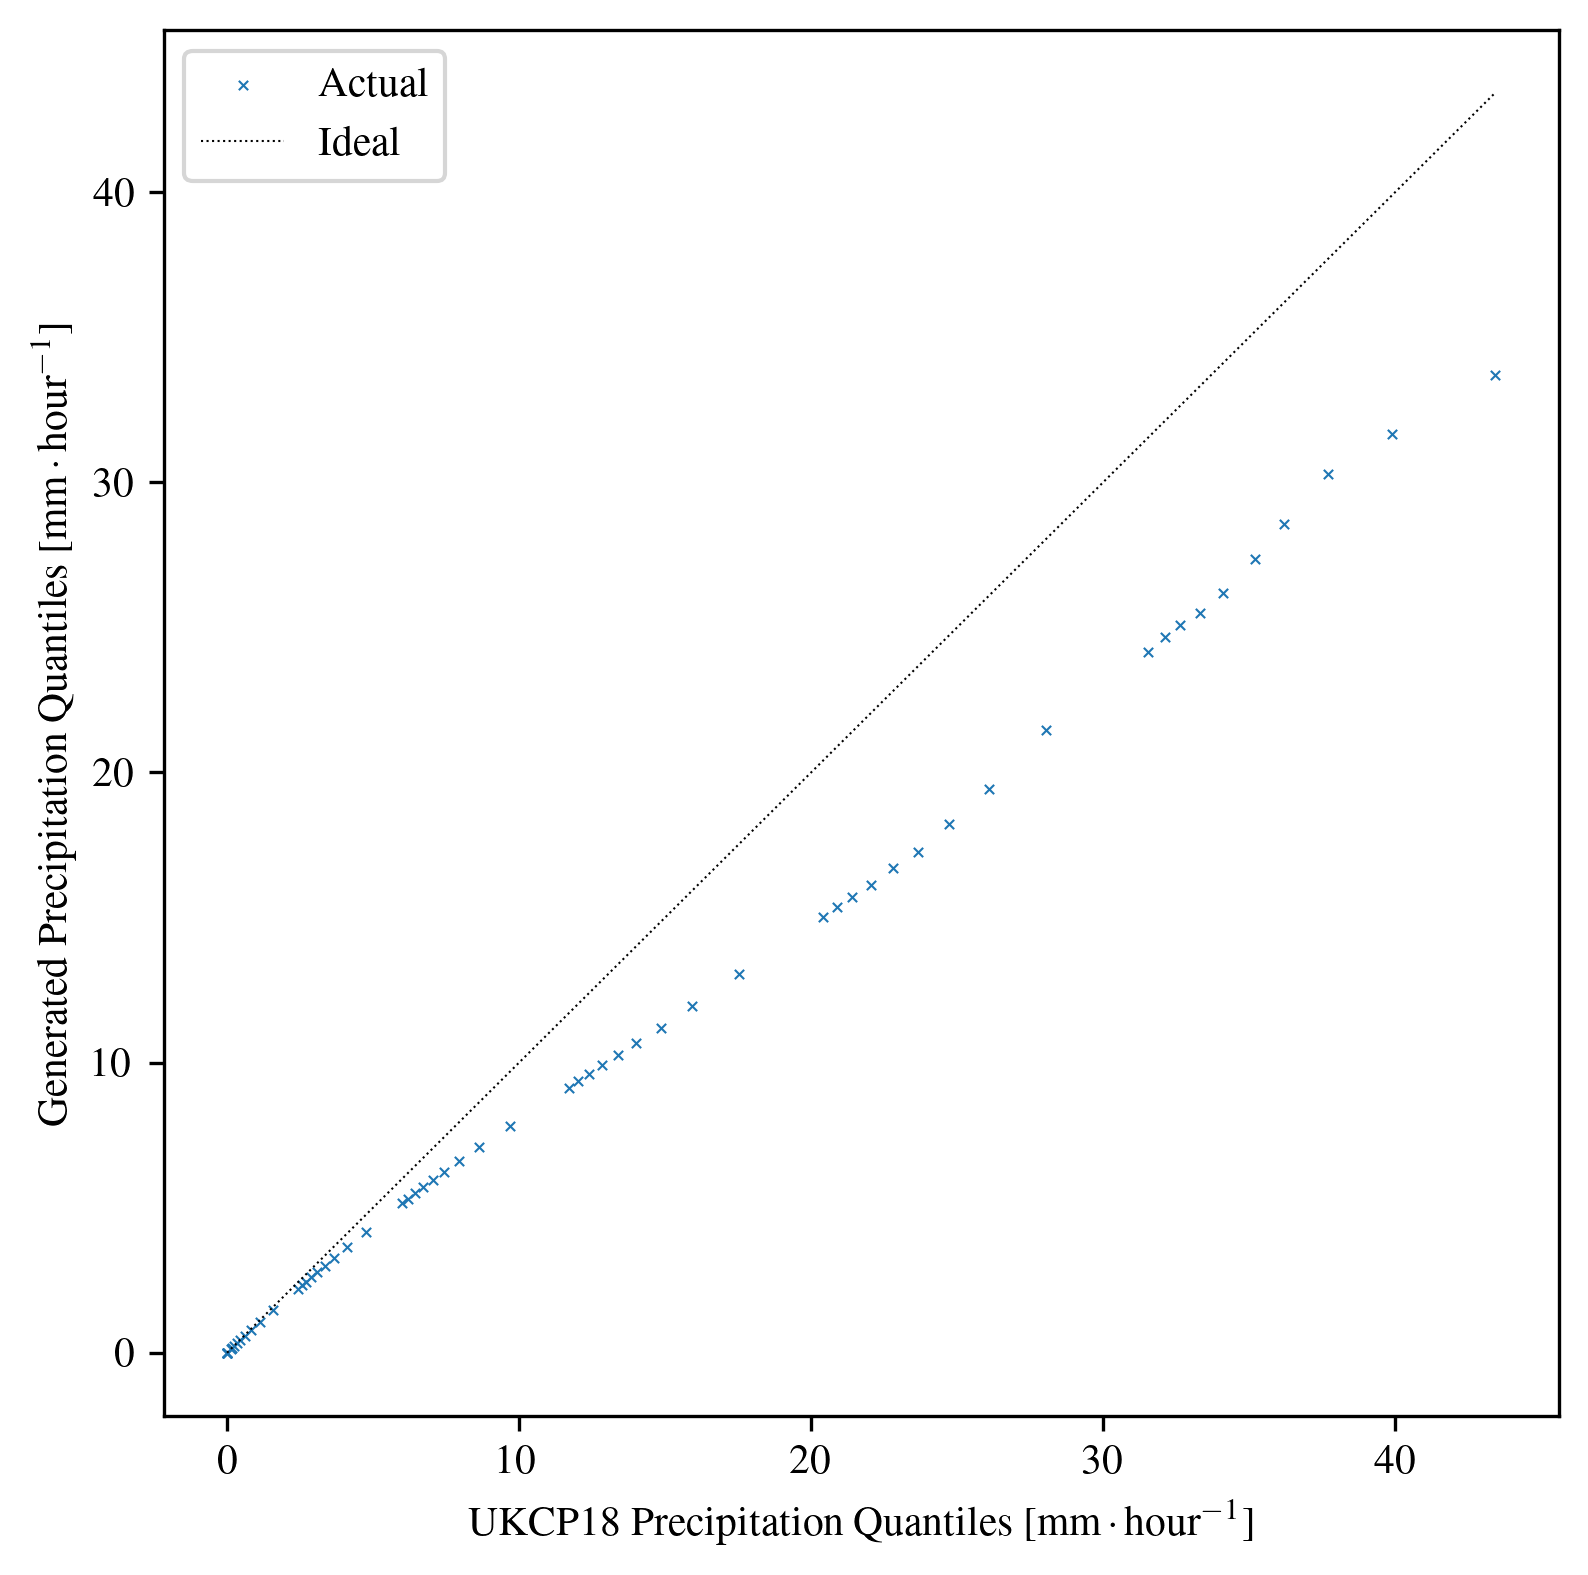

quantile: 0.1000, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.2000, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.3000, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.4000, UKCP18: 0.0000, Generated: 0.0000
quantile: 0.5000, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.6000, UKCP18: 0.0000, Generated: 0.0001
quantile: 0.7000, UKCP18: 0.0000, Generated: 0.0002
quantile: 0.8000, UKCP18: 0.0025, Generated: 0.0017
quantile: 0.9000, UKCP18: 0.1349, Generated: 0.1271
quantile: 0.9100, UKCP18: 0.1845, Generated: 0.1745
quantile: 0.9200, UKCP18: 0.2506, Generated: 0.2374
quantile: 0.9300, UKCP18: 0.3385, Generated: 0.3207
quantile: 0.9400, UKCP18: 0.4560, Generated: 0.4308
quantile: 0.9500, UKCP18: 0.6139, Generated: 0.5780
quantile: 0.9600, UKCP18: 0.8288, Generated: 0.7785
quantile: 0.9700, UKCP18: 1.1299, Generated: 1.0561
quantile: 0.9800, UKCP18: 1.5826, Generated: 1.4682
quantile: 0.9900, UKCP18: 2.4189, Generated: 2.2068
quantile: 0.9910, UKCP18: 2.5534, Generated: 2.3219
quantile: 0.

In [7]:
def get_quantiles(sorted_array, desired_quantiles):
    indices = (len(sorted_array) - 1) * desired_quantiles
    indices_floor = np.floor(indices).astype(int)
    indices_ceil = np.ceil(indices).astype(int)

    indices_fractional_part = indices - indices_floor

    quantiles_floor = sorted_array[indices_floor]
    quantiles_ceil = sorted_array[indices_ceil]

    quantiles = quantiles_floor + indices_fractional_part * (quantiles_ceil - quantiles_floor)

    return quantiles

desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-1, -8, -1)])
# desired_quantiles = 1 - np.geomspace(1, 0.001, 100)
# plt.plot(desired_quantiles)
# plt.show()

test_quantiles = get_quantiles(test_flattend_sorted, desired_quantiles)
samples_quantiles = get_quantiles(samples_flattened_sorted, desired_quantiles)

plt.figure(figsize=(6, 6))
plt.scatter(test_quantiles, samples_quantiles, marker = 'x', s = 5, linewidth = 0.5, label = "Actual")
plt.plot(test_quantiles, test_quantiles, linewidth = 0.5, linestyle=":", c = "black", label = "Ideal")
plt.legend()

plt.xlabel('UKCP18 Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
plt.ylabel('Generated Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.show()

for quantile, test_quantile, sample_quantile in zip(desired_quantiles, test_quantiles, samples_quantiles):
    print(f"quantile: {quantile:.4f}, UKCP18: {test_quantile:.4f}, Generated: {sample_quantile:.4f}")